In [4]:
!pip install transformers
!pip install tensorflow-text



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 18.9 MB/s eta 0:00:00


In [5]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

In [7]:
import pandas as pd

df = pd.read_csv("/content/sample_data/dataset1.csv")
df.head(5)

,page_id,text,label,Pattern Category
0,1012,FLASH SALE | LIMITED TIME ONLY Shop Now,1,Urgency
1,158,Pillowcases & Shams,0,Not Dark Pattern
2,108,Write a review,0,Not Dark Pattern
3,1425,"To start your return, simply click on the foll...",0,Not Dark Pattern
4,1658,newsletter signup (privacy policy),0,Not Dark Pattern


In [8]:
df.groupby('Pattern Category').describe()

page_id                                                   \
                    count         mean         std    min      25%     50%   
Pattern Category                                                             
Forced Action         4.0   878.500000    1.290994  877.0   877.75   878.5   
Misdirection        195.0   853.887179  642.544208  314.0   379.50   436.0   
Not Dark Pattern   1178.0   971.150255  514.704469    4.0   622.00  1009.0   
Obstruction          27.0   895.888889    9.120279  882.0   888.50   895.0   
Scarcity            418.0  1343.485646  204.415282  932.0  1181.50  1343.0   
Sneaking             12.0  1134.583333  383.011383  913.0   920.00   926.5   
Social Proof        312.0   161.634615  128.601910    1.0    78.75   156.5   
Urgency             210.0   794.038095  201.611898  483.0   597.25   772.0   

                                    label                                     
                      75%     max   count mean  std  min  25%  50%  75%  max  
Pattern Category                                                              
Forced Action      879.25   880.0     4.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0  
Misdirection      1716.50  1818.0   195.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0  
Not Dark Pattern  1451.00  1815.0  1178.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
Obstruction        903.00   912.0    27.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0  
Scarcity          1509.75  1698.0   418.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0  
Sneaking          1139.75  1772.0    12.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0  
Social Proof       235.25  1773.0   312.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0  
Urgency           1007.75  1066.0   210.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0

In [9]:
df['Pattern Category'].value_counts()

Not Dark Pattern    1178
Scarcity             418
Social Proof         312
Urgency              210
Misdirection         195
Obstruction           27
Sneaking              12
Forced Action          4
Name: Pattern Category, dtype: int64

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df['text'],df['Pattern Category'],random_state=42)

In [11]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [12]:
X = df['text']
y = df['label']

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [15]:
X_train_bert = bert_preprocess(X_train.values)
X_test_bert = bert_preprocess(X_test.values)

In [16]:
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

In [17]:
pooled_output = outputs['pooled_output']
dropout = tf.keras.layers.Dropout(0.1, name="dropout")(pooled_output)
output = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(dropout)

In [34]:
model = tf.keras.Model(inputs=[text_input], outputs=[output])

In [35]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=METRICS)

In [36]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 text (InputLayer)           [(None,)]                    0         []                            
                                                                                                  
 keras_layer (KerasLayer)    {'input_type_ids': (None,    0         ['text[0][0]']                
                             128),                                                                
                              'input_mask': (None, 128)                                           
                             , 'input_word_ids': (None,                                           
                              128)}                                                               
                                                                                            

In [37]:
len(X_train)

1884

In [39]:
model.fit(X_train_ber, y_train, epochs=3)

Epoch 1/3
59/59 [==============================] - 958s 16s/step - loss: 0.6215 - accuracy: 0.6656 - precision: 0.6629 - recall: 0.6853
Epoch 2/3
59/59 [==============================] - 957s 16s/step - loss: 0.5511 - accuracy: 0.7532 - precision: 0.7656 - recall: 0.7358
Epoch 3/3
59/59 [==============================] - 950s 16s/step - loss: 0.4961 - accuracy: 0.7941 - precision: 0.7964 - recall: 0.7947


In [40]:
model.evaluate(X_test, y_test)

15/15 [==============================] - 239s 16s/step - loss: 0.5058 - accuracy: 0.7924 - precision: 0.7802 - recall: 0.7939


[0.5057787299156189,
 0.7923728823661804,
 0.7801724076271057,
 0.7938596606254578]

In [41]:
y_predicted = model.predict(X_test)
y_predicted = y_predicted.flatten()

15/15 [==============================] - 235s 16s/step


In [42]:
import numpy as np

y_predicted = np.where(y_predicted > 0.5, 1, 0)
y_predicted

array([1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0,
       0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0,
       0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1,
       1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0,
       0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0,
       1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1,
       1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1,
       1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1,
       1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1,

In [43]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test, y_predicted)
cm

array([[193,  51],
       [ 47, 181]])

Text(50.722222222222214, 0.5, 'Truth')

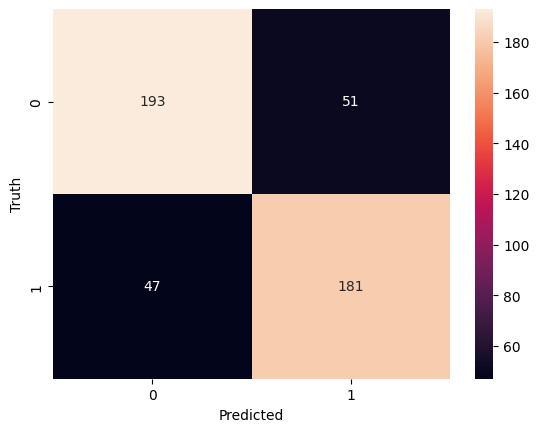

In [44]:
from matplotlib import pyplot as plt
import seaborn as sn
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [45]:
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.80      0.79      0.80       244
           1       0.78      0.79      0.79       228

    accuracy                           0.79       472
   macro avg       0.79      0.79      0.79       472
weighted avg       0.79      0.79      0.79       472

